<a href="https://colab.research.google.com/github/tcapelle/python_ines/blob/master/California_housing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
 !curl https://course-v3.fast.ai/setup/colab | bash

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   665  100   665    0     0   3757      0 --:--:-- --:--:-- --:--:--  3757
    100% |████████████████████████████████| 5.7MB 7.4MB/s 
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
    100% |████████████████████████████████| 576.2MB 29kB/s 
tcmalloc: large alloc 1073750016 bytes == 0x62cf2000 @  0x7f6b57cc22a4 0x591a07 0x5b5d56 0x502e9a 0x506859 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x502209 0x502f3d 0x506859 0x504c28 0x502540 0x502f3d 0x507641 0x504c28 0x502540 0x502f3d 0x507641
Cloning into 'course-v3'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9

# DL model in GPU

In [0]:
from fastai import *          # Quick accesss to most common functionality
from fastai.tabular import *  # Quick accesss to tabular functionality

In [0]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")

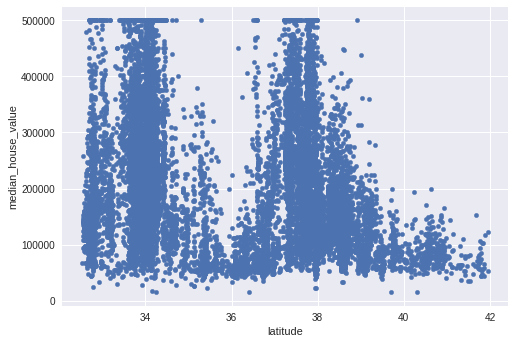

In [4]:
california_housing_dataframe.plot.scatter(x='latitude', y='median_house_value')

In [0]:
california_housing_dataframe['latitude2']=pd.cut(california_housing_dataframe.latitude, bins=[30,33,35,37,39,41,43])

In [0]:
dep_var = 'median_house_value'
cat_names = ['latitude2']
cont_names = ['latitude','longitude', 'housing_median_age', 'total_rooms',
       'total_bedrooms', 'population', 'households', 'median_income']


In [0]:
procs = [FillMissing, Categorify, Normalize]

In [108]:
#random split of train/valid dataframe
np.random.seed(9001)
idx = np.random.permutation(range(17000))[:2000]
idx.sort()
idx

array([    1,     5,    13,    18, ..., 16964, 16972, 16980, 16981])

In [0]:
data = (TabularList.from_df(california_housing_dataframe, cat_names=cat_names, cont_names=cont_names, procs=procs)
                           .split_by_idx(idx)
                           .label_from_df(cols=dep_var, label_cls=FloatList, log=True)
                           .databunch())

In [110]:
data.show_batch(rows=10)

latitude2,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,target
"(33, 35]",-0.7314,0.7641,-0.1277,-0.0572,0.5942,1.8374,0.6027,-0.7339,11.969083786010742
"(30, 33]",-1.2924,1.1732,-0.2071,-0.5986,-0.8094,-0.6871,-0.7488,0.7836,12.471125602722168
"(33, 35]",-0.7734,0.6244,1.8592,-0.4850,-0.5122,-0.5362,-0.5231,-0.3489,11.72964859008789
"(39, 41]",1.8167,-0.9920,0.8260,-0.5055,-0.4446,-0.6603,-0.5019,-0.9719,10.961277961730957
"(33, 35]",-0.7594,0.7392,0.5081,-0.6753,-0.4712,-0.0451,-0.4434,-0.5111,11.924372673034668
"(39, 41]",2.2655,-1.3712,-0.2071,0.0424,0.0337,-0.0870,0.1274,-0.8014,11.097410202026367
"(33, 35]",-0.7641,0.6244,1.2234,-0.4345,-0.4325,-0.5666,-0.6638,-1.1443,11.512925148010254
"(33, 35]",-0.7360,0.6793,0.9055,-0.6949,-0.5171,-0.0620,-0.4727,-1.0325,11.710956573486328
"(33, 35]",-0.8529,0.5546,0.1902,1.0149,0.0917,0.0594,0.2071,4.2749,13.12236499786377
"(37, 39]",1.3491,-0.9720,0.3492,0.1336,-0.2368,-0.3023,-0.1912,0.8633,12.05117130279541


In [0]:
max_log_y = np.log(np.max(california_housing_dataframe[dep_var])*1.2)
y_range = torch.tensor([0, max_log_y], device=defaults.device)

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04, 
                        y_range=y_range, metrics=exp_rmspe)

In [113]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(7, 5)
  )
  (emb_drop): Dropout(p=0.04)
  (bn_cont): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=13, out_features=1000, bias=True)
    (1): ReLU(inplace)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.001)
    (4): Linear(in_features=1000, out_features=500, bias=True)
    (5): ReLU(inplace)
    (6): BatchNorm1d(500, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.01)
    (8): Linear(in_features=500, out_features=1, bias=True)
  )
)

In [114]:
learn.fit_one_cycle(10, 1e-3)

epoch,train_loss,valid_loss,exp_rmspe
1,18.796898,11.509931,0.960472
2,0.486992,0.122071,0.372833
3,0.153860,0.104948,0.350097
4,0.136139,0.089777,0.320877
5,0.111527,0.090098,0.351753
6,0.099332,0.086705,0.328084
7,0.089220,0.076302,0.296502
8,0.082462,0.067593,0.275828
9,0.077673,0.064640,0.273180
10,0.076222,0.064381,0.265460


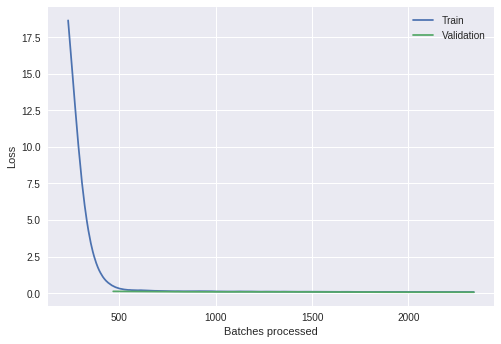

In [115]:
learn.recorder.plot_losses(last=-1)